# Progetto d'esame di Data Analysis in Experimental Physics with Machine Learning

Gruppo composto dagli studenti Luca Attinà, Sharis Feriotto e Matteo Marchisio Caprioglio

Dataset ipotesi: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import os


In [3]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Load the PlantVillage dataset from TFDS
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    shuffle_files=True,
    as_supervised=True,  # returns (image, label) pairs
    with_info=True
)


In [ ]:
# Example: Preprocessing and batching
IMG_SIZE = (128, 128)
BATCH_SIZE = 64
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    image = data_augmentation(image)
    return image, tf.one_hot(label, ds_info.features['label'].num_classes)

def preprocess_with_aug(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = data_augmentation(image)  # <-- augment here
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.one_hot(label, ds_info.features['label'].num_classes)


train_ds = ds_train.map(preprocess_with_aug).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
class_names = ds_info.features['label'].names
print(class_names)


['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___

In [25]:
# ipotesi modello
# convolutional 2d
# relu activation
# maxpooling forse?


In [26]:
from keras.models import Sequential, Model
from keras.layers import Activation, BatchNormalization, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, ReLU, Rescaling
from keras.optimizers.legacy import Adam, SGD
from keras.losses import CategoricalCrossentropy

from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=38):
    model = Sequential([
        Rescaling(1./255, input_shape=input_shape),
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        Dropout(0.2),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = simple_cnn()
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 dropout_1 (Dropout)         (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                 

In [ ]:
optimizer = Adam(learning_rate=0.0002)
# optimizer = SGD(learning_rate=0.05, momentum=0.9)
model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

n_epochs = 30

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=n_epochs,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
    ]
)


Epoch 1/30
679/679 [==============================] - 68s 100ms/step - loss: 3.2846 - accuracy: 0.1595 - val_loss: 3.0426 - val_accuracy: 0.2467 - lr: 2.0000e-04
Epoch 2/30
  1/679 [..............................] - ETA: 1:24 - loss: 3.0587 - accuracy: 0.2188

/Users/2mc/miniconda3/envs/daml/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


679/679 [==============================] - 68s 100ms/step - loss: 2.7410 - accuracy: 0.2842 - val_loss: 2.6434 - val_accuracy: 0.3031 - lr: 2.0000e-04
Epoch 3/30
419/679 [=================>............] - ETA: 23s - loss: 2.4983 - accuracy: 0.3233

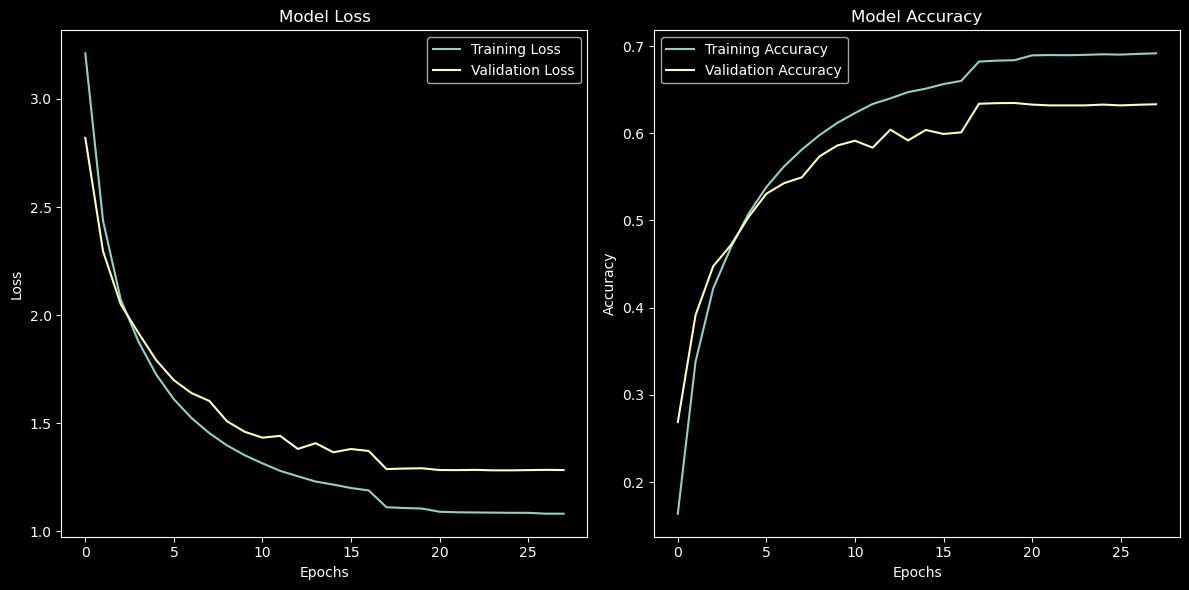

In [12]:
# plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# Plot ROC AUC for each class (one-vs-rest)
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get true labels and predicted probabilities for the validation set
y_true = []
y_score = []

for images, labels in val_ds:
    y_true.append(labels.numpy())
    y_score.append(model.predict(images))

y_true = np.concatenate(y_true)
y_score = np.concatenate(y_score)

# Compute ROC AUC for each class
n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true[:, i], y_score[:, i])


2/2 [==============================] - 0s 3ms/step


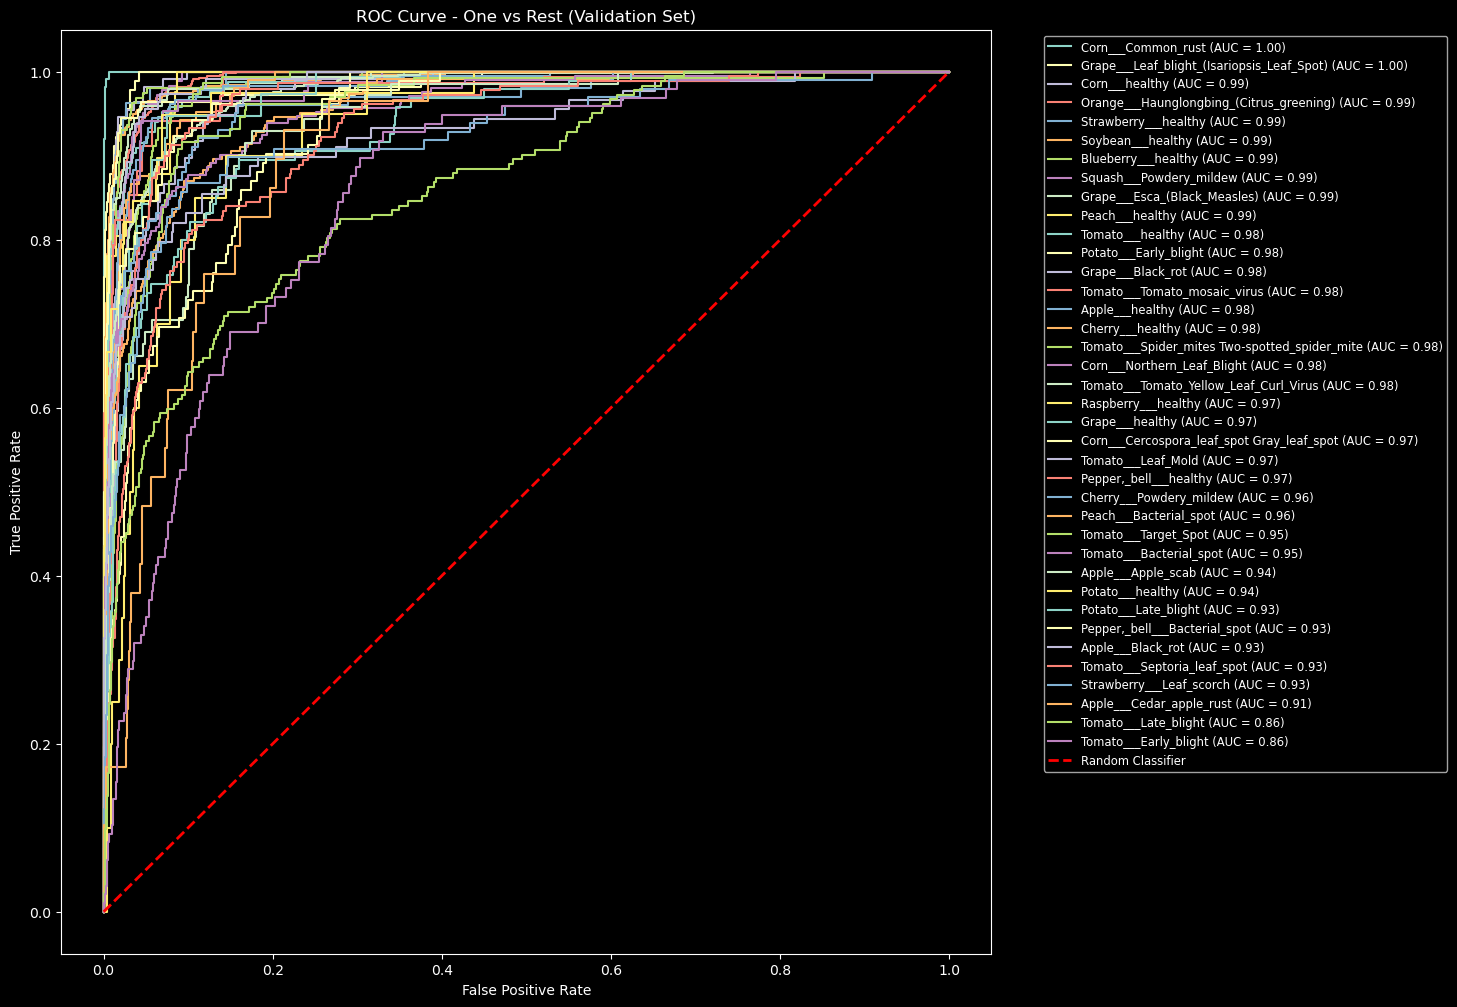

In [16]:
# Plot ROC curve for each class, legend sorted by AUC score
plt.figure(figsize=(12, 12))

# Prepare list of (auc, i) and sort descending
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)

for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Validation Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')


In [17]:
# Plot confusion matrix for the validation set
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true and predicted labels for the validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')


2/2 [==============================] - 0s 5ms/step


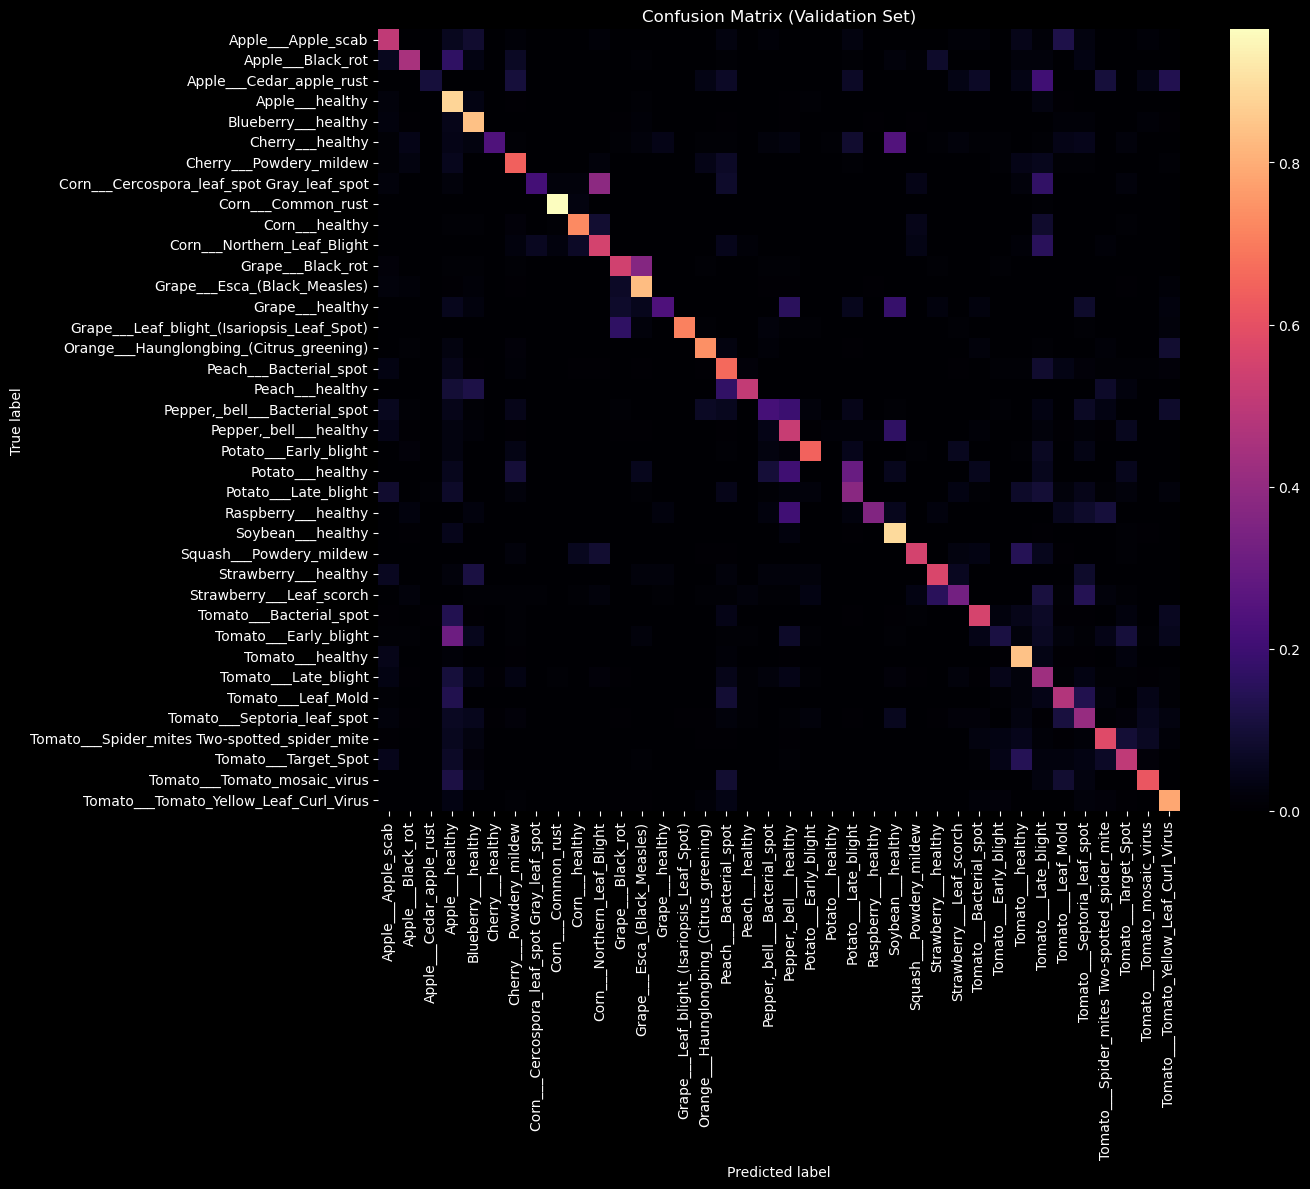

In [18]:
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='magma', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Validation Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
